# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [30]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [31]:
df_content.iloc[1000, 1]

'How I used MapBox and The Weather Company data to create a regional weather forecast'

In [32]:
# convert article id to cat
df.article_id = df.article_id.astype('str')

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

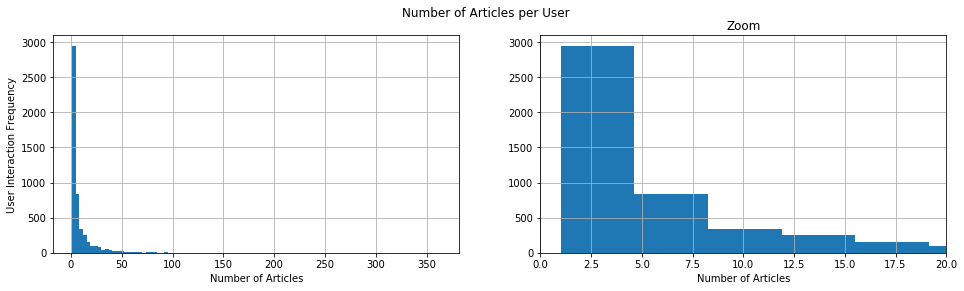

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle('Number of Articles per User')
ax1 = df.groupby('email')['article_id'].count().hist(bins=100, ax=ax[0])
ax1.set_xlabel('Number of Articles')
ax1.set_ylabel('User Interaction Frequency')

ax2 = df.groupby('email')['article_id'].count().hist(bins=100, ax=ax[1])
ax2.set_xlabel('Number of Articles')
ax2.set_ylabel(' ')
ax2.set_title('Zoom')
ax2.set_xlim(0, 20);

In [34]:
df.groupby('email').count().head()

,article_id,title
email,,
0000b6387a0366322d7fbfc6434af145adf7fed1,13,13
001055fc0bb67f71e8fa17002342b256a30254cd,4,4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3,3
001a852ecbd6cc12ab77a785efa137b2646505fe,6,6
001fc95b90da5c3cb12c501d201a915e4f093290,2,2


In [35]:
df.groupby('email')['article_id'].count().describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

There is a large variation in the number of article interactions per user (or user-article interaction frequency) among all articles with some users viewing as little as single article and some as many as 364. The average number of article interactions per user is approximately 9 and median number of interactions is 3. Both the histogram above and the difference between mean and median number of interactions tell us that distribution of article interactions is heavily right skewed with majoirty of users interacting with fewer than 5 articles and a long but thin tail of very high number of single user interactions.

In [36]:
df.groupby('email').article_id.count().median()

3.0

In [37]:
df.groupby('email').article_id.count().max()

364

In [38]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3  # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364  # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [39]:
# Find and explore duplicate articles
df_content.duplicated(subset='article_id').sum()

5

In [40]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset='article_id', keep='first')

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [41]:
unique_articles = df.article_id.nunique()  # The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique()  # The number of unique articles on the IBM platform
unique_users = df.email.nunique()  # The number of unique users
user_article_interactions = df.shape[0]  # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [42]:
df.groupby('article_id').count()[df.groupby('article_id').count()==df.groupby('article_id').count().max()].dropna()

,title,email
article_id,,
1429.0,937.0,937.0


In [43]:
most_viewed_article_id = '1429.0'  # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937  # The most viewed article in the dataset was viewed how many times?

In [44]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [45]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [46]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.groupby(['article_id', 'title']).count()\
                     .sort_values('user_id', ascending=False).head(n)\
                     .index.get_level_values(1).tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.groupby(['article_id']).count()\
                     .sort_values('user_id', ascending=False).head(n)\
                     .index.tolist()
 
    return top_articles # Return the top article ids

In [47]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [48]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [49]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.copy()
    user_item['value'] = 1
    user_item = user_item.groupby(['user_id', 'article_id'])['value'].min().unstack(fill_value=0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [50]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [51]:
user_item.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [52]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    # sort by similarity
    # create list of just the ids
    most_similar_users = pd.Series(np.dot(user_item, user_item.loc[user_id]),
                                   index=user_item.index.copy())\
                           .sort_values(ascending=False)\
                           .index.tolist()
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [53]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [54]:
user_item.loc[2][user_item.loc[2]==1].index.tolist()

['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0']

In [55]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = df[df.article_id.isin(article_ids)].title.unique().tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = np.array(user_item.loc[user_id][user_item.loc[user_id]==1].index)
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = np.array([])
    # get articles for user_id that we don't want to recommend
    user_article_ids, _ = get_user_articles(user_id)
        
    # find similar users
    similar_users = find_similar_users(user_id)
    
    # loop through similar users
    for user in similar_users:
        # get similar user articles
        similar_ids, _ = get_user_articles(user)
        # new recs without articles user_id already read
        recs = np.append(recs, np.setdiff1d(similar_ids, user_article_ids, assume_unique=True))       
        # return only top-m recommendations
        if len(recs) > m:
            recs = recs[:m]
            break
    
    return recs # return your recommendations for this user_id    

In [56]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['analyze energy consumption in buildings',
 'analyze accident reports on amazon emr spark',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'airbnb data for analytics: vancouver listings',
 'recommender systems: approaches & algorithms',
 'airbnb data for analytics: mallorca reviews',
 'analyze facebook data using ibm watson and watson studio',
 'a tensorflow regression model to predict house values']

In [57]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [58]:
temp = pd.DataFrame({'similarity': np.dot(user_item, user_item.loc[1])}, index=user_item.index.copy())\
         .drop(1)\
         .merge(df.groupby('user_id').count().drop(columns=['article_id']), on='user_id')\
         .sort_values(['similarity', 'title'], ascending=[False, False])\
         .reset_index().rename(columns={'user_id': 'neighbor_id', 'title': 'num_interactions'})
         
temp.head()

,neighbor_id,similarity,num_interactions
0,3933,35,45
1,23,17,364
2,3782,17,363
3,203,15,160
4,4459,15,158


In [59]:
df[df.article_id.isin(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])].groupby('article_id').count().sort_values('title', ascending=False).index.tolist()

['1427.0', '1314.0', '1305.0', '1176.0', '1422.0', '1024.0']

In [60]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    neighbors_df = pd.DataFrame({'similarity': np.dot(user_item, user_item.loc[user_id])}, 
                                index=user_item.index.copy())\
                     .drop(user_id)\
                     .merge(df.groupby('user_id').count()
                              .drop(columns=['article_id']), 
                            on='user_id')\
                     .sort_values(['similarity', 'title'], ascending=[False, False])\
                     .reset_index()\
                     .rename(columns={'user_id': 'neighbor_id', 
                                      'title': 'num_interactions'})
    
    return neighbors_df # Return the dataframe specified in the doc_string


def top_sorted_articles(article_ids, df=df):
    '''
    INPUT:
    article_ids - ([str]) list of article ids to sort by number of interactions
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    sorted_ids - ([str]) list of sorted by number of interactions article ids in descending order               
    '''
    return df[df.article_id.isin(article_ids)].groupby('article_id')\
                                              .count()\
                                              .sort_values('title', ascending=False)\
                                              .index.tolist()


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = np.array([])
    # get articles for user_id that we don't want to recommend
    user_article_ids, _ = get_user_articles(user_id)
        
    # find similar users
    similar_users = get_top_sorted_users(user_id).neighbor_id.values
    
    # loop through similar users
    for user in similar_users:
        # get similar user articles
        similar_article_ids, _ = get_user_articles(user)
        # remove articles user_id already read
        similar_article_ids = np.setdiff1d(similar_article_ids, user_article_ids, assume_unique=True)
        # sort articles by number of interactions
        similar_article_ids = top_sorted_articles(similar_article_ids)
        # append to recs
        recs = np.append(recs, similar_article_ids)
        # return only top-m recommendations
        if len(recs) > m:
            recs = recs[:m]
            break
            
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [61]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0' '1427.0' '1364.0' '1170.0' '1162.0' '1304.0' '1351.0' '1160.0'
 '1354.0' '1368.0']

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [62]:
get_top_sorted_users(1).head(1)

,neighbor_id,similarity,num_interactions
0,3933,35,45


In [63]:
get_top_sorted_users(131).head(10)

,neighbor_id,similarity,num_interactions
0,3870,74,144
1,3782,39,363
2,23,38,364
3,203,33,160
4,4459,33,158
5,98,29,170
6,3764,29,169
7,49,29,147
8,3697,29,145
9,242,25,148


In [64]:
### Tests with a dictionary of results

user1_most_sim = 3933  # Find the user that is most similar to user 1 
user131_10th_sim = 242  # Find the 10th most similar user to user 131

In [65]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

### Part III: Q6 RESPONSE:

Assuming we add new user to the **`user_item matrix`** as a row with all zeros we technically will be able to use both the `user_user_recs()` and the `user_user_recs_part2()` functions.

`user_user_recs()` is likely to provide a random set of recommendations, since all users will have an equal 0 similarity with the new user, thus, the most similar set of users and the articles they read will be arbitrary.

`user_user_recs_part2()` is an improvement over the method above because the list of recommended articles will come from the user(s) with the most article interactions, with articles sorted in the order of their popularity. However, if new user will turn out to have taste dissimilar to the subset of most active users, the recommendations using this method will be more irrelevant.

An improvement on the `user_user_recs_part2()` method of using article popularity from the subset of most active readers is to use rank based recommendations from the entire population of users. This is a typical solution to cold-start problems and can be accomplished in our case using the `get_top_articles()` function. This type of recommendation is completely independent of the specific user preference and is based purely on the overall popularity.  


`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [66]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)  # Your recommendations here



In [67]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [68]:
# clean doc_description missing values by substituting doc_full_name
articles = df_content[['article_id', 'doc_full_name', 'doc_description']]
articles['doc_description'].fillna(articles.doc_full_name, inplace=True)
articles.head()

C:\Users\Alexander\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,article_id,doc_full_name,doc_description
0,0,Detect Malfunctioning IoT Sensors with Streami...,Detect bad readings in real time using Python ...
1,1,Communicating data science: A guide to present...,"See the forest, see the trees. Here lies the c..."
2,2,"This Week in Data Science (April 18, 2017)",Here’s this week’s news in Data Science and Bi...
3,3,DataLayer Conference: Boost the performance of...,Learn how distributed DBs solve the problem of...
4,4,Analyze NY Restaurant data using Spark in DSX,This video demonstrates the power of IBM DataS...


In [69]:
# Check for missing values
df_content[df_content.doc_description.isna()]

,doc_body,doc_description,doc_full_name,doc_status,article_id
354,The search index lets you create flexible quer...,NaN,Build the search index in Cloudant,Live,354
768,Compose The Compose logo Articles Sign in Free...,NaN,Announcing the Data Browser for JanusGraph,Live,765
919,Cloudant Query is a powerful declarative JSON ...,NaN,Use the new Cloudant query,Live,916


In [70]:
articles.isna().sum()

article_id         0
doc_full_name      0
doc_description    0
dtype: int64

In [71]:
# check whether all article descriptions table df_content
# contains all article ids found in user interaction table df
len(np.setdiff1d(list(map(int, map(float, df.article_id.unique()))), df_content.article_id.values))

277

There are 277 articles found in the user interactions `df` table without description in the article description table `df_content`. For users who read only such articles, we will use article titles from `df` table instead of descriptions to find similar articles for recommendations.

In [72]:
import spacy
nlp = spacy.load("en_core_web_sm")

from sklearn.feature_extraction.text import TfidfVectorizer

In [73]:
def tokenize(text):
    """ Return lowercase lemmatized tokens of the input text. 
        Remove punctuation, spacy.stop_words, and pronouns.
    
    Args:
        text (str): input text
    Returns:
        tokens ([str]): list of lower case lemmatized tokens
    """
    
    doc = nlp(text)
    tokens = [tok.lemma_.lower() for tok in doc
              if (not tok.is_stop) and (not tok.is_punct) and (tok.lemma_ != '-PRON-')]
    return tokens

def pairwise_similarity(documents):
    """ Return pairwise cosine similarities between input documents
    Args:
        docs ([str]): list of input documents
        
    Returns:
        similarity_matrix (np.array): arry containing pariwise cosine similarities between documents
    """
    # TF-IDF Vectorize input documents
    vect = TfidfVectorizer(tokenizer=tokenize)                                                                                                                                                                                                   
    tfidf = vect.fit_transform(documents)
    
    # calculate similarity matrix
    pairwise_similarity = (tfidf * tfidf.T).toarray()
    
    # replace diagonal elements (self-similarity) with missing values
    # since we don't want to return self in the similar articles set
    np.fill_diagonal(pairwise_similarity, np.nan)
        
    return pairwise_similarity


def description_article_similarity_matrix(df=df_content):
    """ Return dataframe containing cosine similarity matrix using article descirptions from df_content frame
    
    Args:
        df (pd.DataFrame): input frame containing articles and their descirptions.
                           Required columns: 'article_id', 'doc_full_name', 'doc_description'
    
    Returns:
        similarity_matrix (pd.DataFrame): article-article cosine similarity matrix with indices and columns
                                          corresponding to article ids and N/A in diagonal cells
    """
    assert all(x in df for x in ['article_id', 'doc_full_name', 'doc_description']), "Error: Required columns are missing"
    
    # get required columns
    articles = df[['article_id', 'doc_full_name', 'doc_description']]
    
    # fill in missing descriptions with article titles
    articles['doc_description'].fillna(articles.doc_full_name, inplace=True)
    
    labels = list(map(int, map(float, articles.article_id.values)))
    # create similarity matrix
    similarity_matrix = pd.DataFrame(pairwise_similarity(articles.doc_description.values), 
                                     index=labels, columns=labels)
    
    return similarity_matrix


def title_article_similarity_matrix(df=df):
    """ Return dataframe containing cosine similarity matrix using article descirptions from df_content frame
    
    Args:
        df (pd.DataFrame): input frame containing articles and their descirptions.
                           Required columns: 'article_id', 'title'
    
    Returns:
        similarity_matrix (pd.DataFrame): article-article cosine similarity matrix with indices and columns
                                          corresponding to article ids and N/A in diagonal cells
    """
    assert all(x in df for x in ['article_id', 'title']), "Error: Required columns are missing"
    
    articles = df.copy()
    
    # get single article_id-title pairs
    articles = df.groupby(['article_id', 'title']).count().reset_index()
    
    labels = list(map(int, map(float, articles.article_id.values)))
    # create similarity matrix
    similarity_matrix = pd.DataFrame(pairwise_similarity(articles.title.values), 
                                     index=labels, columns=labels)
    
    return similarity_matrix

In [74]:
description_similarity_matrix = description_article_similarity_matrix(df_content)

C:\Users\Alexander\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [75]:
description_similarity_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050
0,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.039713,0.050213,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
1,0.0,NaN,0.041637,0.008056,0.0,0.000000,0.033879,0.007459,0.166548,0.032236,...,0.000000,0.009208,0.050438,0.006412,0.0,0.0,0.016856,0.082777,0.022088,0.0
2,0.0,0.041637,NaN,0.042394,0.0,0.000000,0.000000,0.039251,0.141794,0.102332,...,0.084539,0.102189,0.044668,0.033743,0.0,0.0,0.000000,0.000000,0.116239,0.0
3,0.0,0.008056,0.042394,NaN,0.0,0.000000,0.000000,0.007594,0.040082,0.012737,...,0.000000,0.009375,0.008642,0.006528,0.0,0.0,0.104373,0.023169,0.051077,0.0
4,0.0,0.000000,0.000000,0.000000,NaN,0.053559,0.000000,0.018111,0.032015,0.000000,...,0.017682,0.043387,0.000000,0.000000,0.0,0.0,0.000000,0.036574,0.025225,0.0


In [76]:
title_similarity_matrix = title_article_similarity_matrix(df)
title_similarity_matrix.head()

,0,100,1000,1004,1006,1008,101,1014,1015,1016,...,977,98,981,984,985,986,990,993,996,997
0,NaN,0.0,0.000000,0.0000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.037272,0.058681
100,0.0,NaN,0.000000,0.0000,0.000000,0.000000,0.31269,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.094143,0.000000,0.097174,0.0,0.081252,0.000000
1000,0.0,0.0,NaN,0.0000,0.248946,0.000000,0.00000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1004,0.0,0.0,0.000000,NaN,0.115300,0.118677,0.00000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1006,0.0,0.0,0.248946,0.1153,NaN,0.000000,0.00000,0.0,0.0,0.098026,...,0.0,0.0,0.081882,0.0,0.000000,0.207287,0.000000,0.0,0.000000,0.000000


In [77]:
title_similarity_matrix[sorted(title_similarity_matrix.columns)].sort_index(ascending=True).head()

,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
0,NaN,0.000000,0.000000,0.000000,0.000000,0.16953,0.039977,0.128691,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,0.0,NaN,0.055537,0.359379,0.000000,0.00000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.073285,0.035479,0.0,0.0,0.0
4,0.0,0.055537,NaN,0.068818,0.061028,0.00000,0.000000,0.127138,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.067517,0.032687,0.0,0.0,0.0
8,0.0,0.359379,0.068818,NaN,0.000000,0.00000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.090810,0.043963,0.0,0.0,0.0
9,0.0,0.000000,0.061028,0.000000,NaN,0.00000,0.000000,0.148738,0.0,0.0,...,0.0,0.0,0.0,0.0,0.100843,0.000000,0.000000,0.0,0.0,0.0


In [78]:
# get user articles to avoid recommending already read ones
user_article_ids, _ = get_user_articles(5)
user_article_ids = list(map(int, map(float, user_article_ids)))  # convert to integer
user_article_ids

[1166, 1276, 1351]

In [79]:
if not any(x in df_content.article_id for x in user_article_ids):
    # none of user articles have descriptions
    similarity_matrix = title_similarity_matrix
else:
    similarity_matrix = description_similarity_matrix
# subsetting rows corresponding to articles ids read by user
user_similarity_subset = similarity_matrix[similarity_matrix.index.isin(user_article_ids)]
user_similarity_subset

,0,100,1000,1004,1006,1008,101,1014,1015,1016,...,977,98,981,984,985,986,990,993,996,997
1166,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.038476,0.0,0.0,...,0.0,0.0,0.00000,0.069081,0.0,0.114411,0.0,0.0,0.0,0.0
1276,0.0,0.0,0.0,0.0,0.090019,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.08608,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1351,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.036620,0.0,0.0,...,0.0,0.0,0.00000,0.065748,0.0,0.108891,0.0,0.0,0.0,0.0


In [80]:
user_similarity_subset.stack().sort_values(ascending=False)\

1166  935     0.506407
      809     0.312529
1351  693     0.306602
1276  1274    0.291633
1166  1017    0.278600
                ...   
1276  793     0.000000
      8       0.000000
      800     0.000000
      805     0.000000
1166  0       0.000000
Length: 2139, dtype: float64

In [81]:
# get ids of top-similarity sorted articles
top_ids = user_similarity_subset.stack().sort_values(ascending=False)\
                                .reset_index(level=0, drop=True)\
                                .index.values
top_ids[:10]

array([ 935,  809,  693, 1274, 1017,  686,  906, 1432,  958,  130],
      dtype=int64)

In [82]:
# remove ids from articles user already read
top_ids_clean = [str(x) + '.0' for x in top_ids if x not in user_article_ids]

recs = get_article_names(top_ids_clean)

# return top m results
recs[:10]


['using pixiedust for fast, flexible, and easier data analysis and experimentation',
 'healthcare python streaming application demo',
 'use deep learning for image classification',
 'ml optimization using cognitive assistant',
 'visualize data with the matplotlib library',
 'upload files to ibm data science experience using the command line',
 'classify tumors with machine learning',
 'configuring the apache spark sql context',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'the unit commitment problem']

In [83]:
def make_content_recs(user_id, m=10):
    '''
    INPUT:
        user_id (int): user id for whom recommendations are to be generated
        m (int): number of recommendations to return
    
    OUTPUT:
        recs ([str]): list of recommended article titles
    '''
    # provide recommendations to new user
    if user_id not in df.user_id.unique():  
        recs = get_article_names(get_top_article_ids(m))
        return recs
    
    # get user articles to avoid recommending already read ones
    user_article_ids, _ = get_user_articles(user_id)
    user_article_ids = list(map(int, map(float, user_article_ids)))  # convert to integer
    
    if not any(x in df_content.article_id for x in user_article_ids):
        # none of user articles have descriptions
        similarity_matrix = title_similarity_matrix
    else:
        similarity_matrix = description_similarity_matrix
  
    # subsetting rows corresponding to articles ids read by user
    user_similarity_subset = similarity_matrix[similarity_matrix.index.isin(user_article_ids)]
    
    # get ids of top-similarity sorted articles
    top_ids = user_similarity_subset.stack().sort_values(ascending=False)\
                                    .reset_index(level=0, drop=True)\
                                    .index.values
    
    # remove ids from articles user already read
    top_ids_clean = [str(x) + '.0' for x in top_ids if x not in user_article_ids]
    
    recs = get_article_names(top_ids_clean)
    
    # return top m results
    recs = recs[:m]
    
    return recs

In [84]:
make_content_recs(100, 10)

['configuring the apache spark sql context',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'getting started with python',
 'timeseries data analysis of iot events by using jupyter notebook',
 '10 must attend data science, ml and ai conferences in 2018',
 'dsx: hybrid mode',
 'data science for real-time streaming analytics',
 'web picks - dataminingapps',
 'common excel tasks demonstrated in\xa0pandas',
 'ibm data science experience white paper - sparkr transforming r into a tool for big data analytics']

In [85]:
make_content_recs(-1, 10)

['healthcare python streaming application demo',
 'use deep learning for image classification',
 'apache spark lab, part 1: basic concepts',
 'predicting churn with the spss random tree algorithm',
 'analyze energy consumption in buildings',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'gosales transactions for logistic regression model',
 'insights from new york car accident reports',
 'finding optimal locations of new store using decision optimization']

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

### Part IV: Q2 Answer: Content Recommender explanation
The content-based recommender function `make_content_recs()` works as follows:
- Input user_id is checked against user_ids found in the user-article-interaction table (df)
- If user id is not found, user is assumed to be new and rank-based recommendations are provided with `get_top_articles()` function
- If user_id is found, then the following steps are taken:
  - retrieve id's of all articles with which user interacted
  - use article similarity matrix to find articles most similar to the ones with which user has already interacted
    - if user read articles have descriptions in `df_content` table then use article descirptions to find similar articles. Otherwise use article titles from `df` frame
    - use **`spacy`** module to parse and tokenize text in article descriptions / titles
    - use TF-ID vectorization to create a sparse matrix of text features for each article from the generated tokens
    - build article-article cosine similarity matrix
    - subset similarity matrix with rows corresponding to user read articles
    - sort the resultant subset of articles by decreasing order of similarity, keeping track of article ids using stack and indices
    - remove articles user has already interacted with
    - return top article titles as recommendations
    
If user has no article interactions, recommendations will consist of most popular by the entire user base articles (ranked-based recommendations). In other cases, recommendations will contain most similar articles (by description, if availble, otherwise by title) to the articles that user has already interactived with. Recommendations are sorted by overall decreasing similarity to all articles user has already read.

Further improvements can be made by analyzing text using word2vec and clustering resultant embeddings into topics and subsequently recommending articles that belong to similar topics.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [86]:
# make recommendations for a brand new user
make_content_recs(user_id=-1)

['healthcare python streaming application demo',
 'use deep learning for image classification',
 'apache spark lab, part 1: basic concepts',
 'predicting churn with the spss random tree algorithm',
 'analyze energy consumption in buildings',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'gosales transactions for logistic regression model',
 'insights from new york car accident reports',
 'finding optimal locations of new store using decision optimization']

In [87]:
# make a recommendations for a user who only has interacted with article id '1427.0'
# subsetting rows corresponding to articles ids read by user
user_article_ids = [1427]

user_similarity_subset = title_similarity_matrix[title_similarity_matrix.index.isin([1427])]

# get ids of top-similarity sorted articles
top_ids = user_similarity_subset.stack().sort_values(ascending=False)\
                                .reset_index(level=0, drop=True)\
                                .index.values

# remove ids from articles user already read
top_ids_clean = [str(x) + '.0' for x in top_ids if x not in user_article_ids]

recs = get_article_names(top_ids_clean)

# return top 10 results
recs = recs[:10]

recs

['using pixiedust for fast, flexible, and easier data analysis and experimentation',
 'healthcare python streaming application demo',
 'use deep learning for image classification',
 'ml optimization using cognitive assistant',
 'deploy your python model as a restful api',
 'visualize data with the matplotlib library',
 'upload files to ibm data science experience using the command line',
 'classify tumors with machine learning',
 'configuring the apache spark sql context',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium']

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [88]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [89]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [90]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

In [91]:
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

### Part V: Q2 ANSWER:
In the lesson, the user-movie matrix that contained ratings scaled 1-10. Such matrices are typically very sparse since most users rate only few movies and the remaining interaction cells are missing values (NA). Standard SVD cannot be performed on matrices with missing values.   
  
In the case of this project, we are using binary 0-1 to show whether any kind of user-article interaction have occurred. As a result, the user-article matrix is full without any missing values, populated with 1's for any interactions and zeros where no user-article interaction has occured. This allows us to perform standard SVD transformation.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

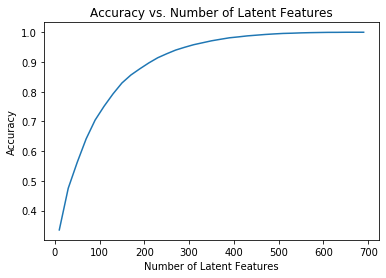

In [92]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [93]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = np.array(user_item_test.index)
    test_arts = np.array(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [94]:
user_item_train.shape

(4487, 714)

In [95]:
df_train.user_id.nunique()

4487

In [96]:
# number of users in test data we cannot make predictions for because they are not in the training data
num_no_user_preds = len(np.setdiff1d(user_item_test.index.values, user_item_train.index.values))
num_no_user_preds

662

In [97]:
# number of users in test data we can make predictions for because they are not in the training data
num_user_preds = user_item_test.shape[0] - num_no_user_preds
num_user_preds

20

In [98]:
# number of articles that we cannot make predictions for because they are not in the training data
len(np.setdiff1d(user_item_test.columns, user_item_train.columns))

0

In [99]:
# number of articles we can make predictions for
len(user_item_test.columns)

574

In [100]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [101]:
# fit SVD on the user_item_train matrix
u_train, s, vt_train = np.linalg.svd(user_item_train)
u_train.shape, s.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [102]:
# select only rows and columns from u_train and vt_train
# corresponding to users and articles found in test data set
u_test = u_train[user_item_train.index.isin(test_idx), :]
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]
u_test.shape, s.shape, vt_test.shape

((20, 4487), (714,), (714, 574))

In [103]:
# test data select only users and articles present in training data
test_set = user_item_test.loc[user_item_test.index.isin(user_item_train.index), 
                              user_item_test.columns.isin(user_item_train.columns)]
test_set.shape

(20, 574)

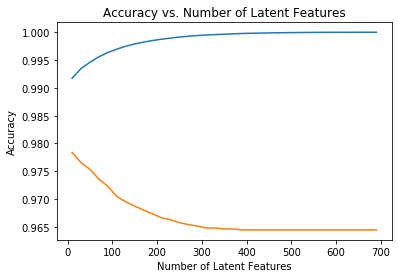

In [104]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test = []

for k in num_latent_feats:
    # restructure with k latent features
    s_k = np.diag(s[:k])  # latent feature matrix with k-features
    u_train_k, vt_train_k = u_train[:, :k], vt_train[:k, :]
    u_test_k, vt_test_k = u_test[:, :k], vt_test[:k, :]

    # take dot product
    preds_train = np.around(np.dot(np.dot(u_train_k, s_k), vt_train_k))
    preds_test = np.around(np.dot(np.dot(u_test_k, s_k), vt_test_k))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, preds_train)
    diffs_test = np.subtract(test_set, preds_test)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    sum_errs_train.append(err_train)
    
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(err_test)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0] * user_item_train.shape[1]));
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(test_set.shape[0] * test_set.shape[1]));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

### Part V: Q6 Answer:
Very few of the users in the test set are present in the training set creating a train/test mismatch. Because the performance of our model increases on the training set and decreases on the test set with increase in the number of latent features, we can conclude that model is overfitting and not generalizing well for large number of latent features.

In order to test whether any of our recommendation systems provide an improvement into how users currently find articles, we can design and A/B test experiment as follows (below is only one of a number of tests we can perform):
- Define metric:
  - Track number of user-article interactions per user (hoping to find overall increased user interest in articles)
  - Track unique number of user-article interactions (hoping to find wider range of articles being read by any given user)
- Determine required duration of the experiment
  - Statistical power test, depending on the size of the change we'd like to see and the rate of user visit to the site
- Split users into Control and Experiment groups **randomly** by using a cookie on the main article recommendaion/search page
  - Control group continues to find articles as before
  - Experiment group provides an **additional** section (change only one thing at a time) of recommended articles that uses the new recommendation engine, if one doesn't exist, or changes the recommendation engine if one has already been used before. 
- Collected data and analyze as follows
  - Compare distributions of users in Control and Experiment groups to ensure that groups are not statistically significantly different from each other (both by number of users and by their characteristics/properties, if those are available)
  - Compare distributions of the numer of user-article interactions and unique interactions for Control and Experiment groups using one-sided hypothesis testing (we are looking only for positive change)
  
If we find that distributions of users in Control and Experiment groups are not statistically significant and that our hypothesis tests produce statistically significant results (p-value <0.05) we can conclude that our new recommendation engine is an improvement over previous system and can be fully deployed on our site.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [105]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0